In [143]:
import imageio
import numpy as np
import scipy

In [144]:
# Calculate error
def root_mean_sq_err(ref_image, gen_image):
    n, m = gen_image.shape
    subtracted_image = gen_image.astype(float) - ref_image.astype(float)
    squared_image = np.square(subtracted_image)
    mean_image = squared_image/(n*m)
    err = np.sum(mean_image)
    
    return np.sqrt(err)


In [145]:
def fft(image: np.ndarray) -> np.ndarray:
    """Applies the Fast Fourier Transform to an image and returns its result.

    Arguments:
        image: The image in spacial domain.

    Returns:
        The image in Frequency domain.
    """
    freq_image = np.fft.fftn(image)
    return freq_image

def ifft(image: np.ndarray) -> np.ndarray:
    """Applies the Inverse Fast Fourier Transform to an image and returns its result.

    Arguments:
        image: The image in frequency domain and shifted.

    Returns:
        The image in spacial domain.
    """
    spac_image = np.fft.ifftn(image)
    return spac_image.real

def pad(small: np.ndarray, big: np.ndarray) -> np.ndarray:
    pad_size = int(big.shape[0]//2 - small.shape[0]//2)
    padded = np.pad(small, (pad_size, pad_size), 'constant')
    return padded

In [146]:
def gaussian_filter(k, sigma):
    range = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(range, range)
    fil = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    norm_filter = fil / np.sum(fil)
    return norm_filter


def apply_gaussian_filter(image: np.ndarray, k: int, sigma: float):
    """Changes the image received by applying a Gaussian blur filter to it.
    
    Arguments:
        image: The original image in space domain.
        k: Size of the side of the square matrix filter.
        sigma: Standard deviation for the Gaussian filter generation.
    
    Returns:
        A tuple containing a new image with Gaussian filter applied and the filter itself.
    """
    
    gaussian_f = gaussian_filter(k, sigma)
    padded_filter = pad(gaussian_f, image)
    freq_filter = fft(padded_filter)
    freq_image = fft(image)
    blurred_image = np.multiply(freq_image, freq_filter)
    return np.fft.fftshift(ifft(blurred_image)), gaussian_f

In [147]:
def clsq(image: np.ndarray, psf: np.ndarray, gamma: float) -> np.ndarray:
    """Constrained Least Squares method application.

    Arguments:
        image: The blurred image in frequency domain (G).
        psf: The point-spread-function representing the blur in the image (H).
        gamma: The multiplication parameter to the laplacian operator.

    Returns:
        The restored image after CLSQ application.
    """
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    padded_lap = pad(laplacian, image)
    padded_psf = pad(psf, image)
    G = fft(image)
    P = fft(padded_lap)
    H = fft(padded_psf)

    restored_image = (H.conj()/(np.square(np.abs(H)) + (gamma * np.square(np.abs(P))))) * G
    restored_space_image = np.fft.fftshift(ifft(restored_image))
    restored_space_image = np.clip(restored_space_image, 0, 255)
    return restored_space_image.astype(np.uint8)

In [148]:
def conv_point_2d(image, weights, x, y, a, b):
    sub_image = image[x-a:x+a+1, y-b:y+b+1]
    res = np.sum(np.multiply(sub_image, weights))
    return int(res)

def convolve_2d(big, small):
    rows, cols = big.shape
    n, m = small.shape
    a = int(rows//2 - n//2)
    b = int(cols//2 - m//2)
    small_flipped = np.flip(np.flip(small, 0), 1)
    big_padded = np.pad(big, (a, b), 'edge')
    result = np.zeros(big.shape)

    for i in range(a, rows):
        for j in range(b, cols):
            result[i-a, j-b] = conv_point_2d(big_padded, small_flipped, i, j, a, b)
    
    return result

In [149]:
def get_motion_psf(
        dim_x: int, dim_y: int, degree_angle: float, num_pixel_dist: int = 20)-> np.ndarray:
    """Essa função retorna uma array representando a PSF para um dado ângulo em graus

    Parameters:
    -----------
        dim_x: int
            The width of the image.
        dim_y: int
            The height of the image.
        degree_angle: float
            The angle of the motion blur. Should be in degrees. [0, 360)
        num_pixel_dist: int
            The distance of the motion blur. [0, \infinity).
            Remember that the distance is measured in pixels.
            Greater will be more blurry.
    
    Returns:
    --------
        np.ndarray
            The point-spread array associated with the motion blur.

    """
    psf = np.zeros((dim_x, dim_y))
    center = np.array([dim_x-1, dim_y-1])//2
    radians = degree_angle/180*np.pi
    phase = np.array([np.cos(radians), np.sin(radians)])
    for i in range(num_pixel_dist):
        offset_x = int(center[0] - np.round_(i*phase[0]))
        offset_y = int(center[1] - np.round_(i*phase[1]))
        psf[offset_x, offset_y] = 1 
    psf /= psf.sum()
 
    return psf 

def richardson_lucy_filter(
        image: np.ndarray, psf: np.ndarray, max_iter: int=50) -> np.ndarray:
    """
    Parameters:
    ----------
        image : np.ndarray
            Your degraded image (grayscale)
        psf : np.ndarray
        max_iter : int
            maximum number of iterations
    Returns
    -------
        np.ndarray
    """
    O_k = np.ones(image.shape)
    O_next = np.copy(O_k)
    # H = pad(psf, image)
    # H = fft(H)
    # I = fft(image)
    epsilon = 0.001
    for _ in range(max_iter): 
        denom = convolve_2d(O_k, psf)
        frac = image/(denom + epsilon)
        partial = convolve_2d(frac, np.flip(psf)) 
        O_next = O_k * partial
        O_k = O_next
    
    restored = ifft(O_k)
    restored = np.clip(restored, 0, 255)
    print(restored.max(), restored.min())
    return restored.astype(np.uint8)


In [150]:
BASE_DIR = '../tests/resources/'
in_image_filename = 'img_45.jpg'
method = 2
if method == 1:
    k = 3
    sigma = 2.0
    gamma = 0.1
    base_image = imageio.imread(BASE_DIR + in_image_filename)
    degraded, psf = apply_gaussian_filter(base_image, k, sigma)
    restored = clsq(degraded, psf, gamma)
else:
    angle = 45
    steps = 20
    base_image = imageio.imread(BASE_DIR + in_image_filename)
    restored = richardson_lucy_filter(base_image, get_motion_psf(base_image.shape[0], base_image.shape[1], degree_angle=45), steps)


rmse = root_mean_sq_err(base_image, restored)
print(f'{rmse:.4f}')

0.0 0.0
53.2760


Text(0.5, 1.0, 'Restored image')

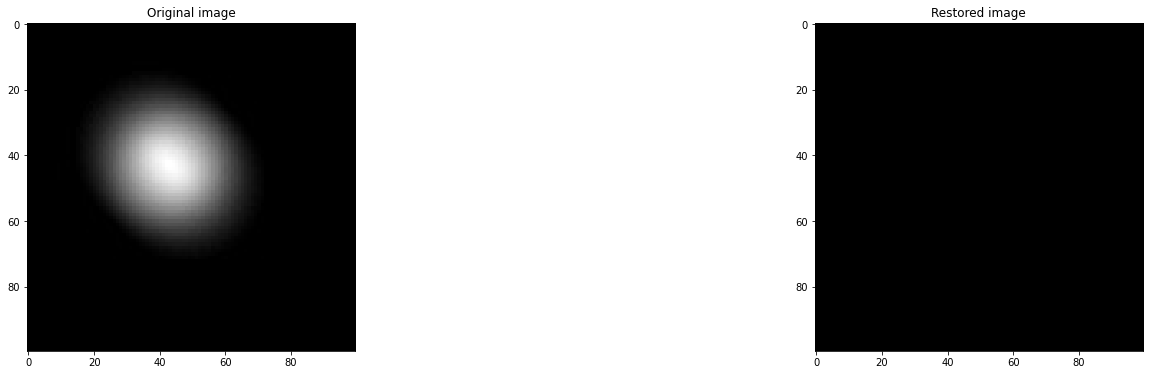

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(base_image, "gray", vmin=0, vmax=255)
plt.title("Original image")
# plt.subplot(132)
# plt.imshow(degraded, "gray")
# plt.title("Degraded image")
plt.subplot(133)
plt.imshow(restored, "gray")
plt.title("Restored image")